<a href="https://colab.research.google.com/github/0su1327/Graduation_Thesis/blob/main/Autoencoder_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# 시각화 라이브러리 설정
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["anomal", "normal"]

In [ ]:
df = pd.read_csv("/content/dataset_sdn.csv", error_bad_lines = False)

<ipython-input-42-b9f373db7481>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("/content/dataset_sdn.csv", error_bad_lines = False)


In [ ]:
df.shape

(104345, 23)

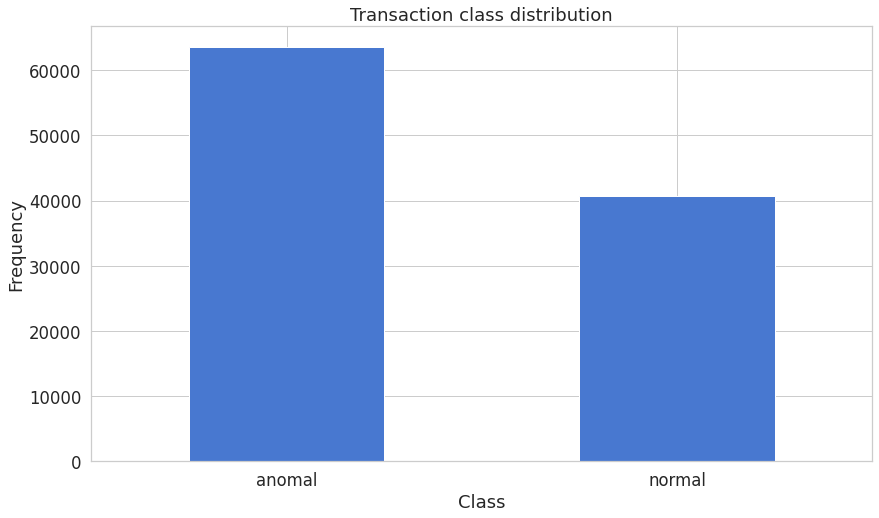

In [ ]:
count_classes = pd.value_counts(df['label'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [ ]:
dos = df[df.label == 0]
normal = df[df.label == 1]
dos.shape

(63561, 23)

In [ ]:
normal.shape

(40784, 23)

In [ ]:
normal.Protocol.describe()

count     40784
unique        3
top         UDP
freq      17499
Name: Protocol, dtype: object

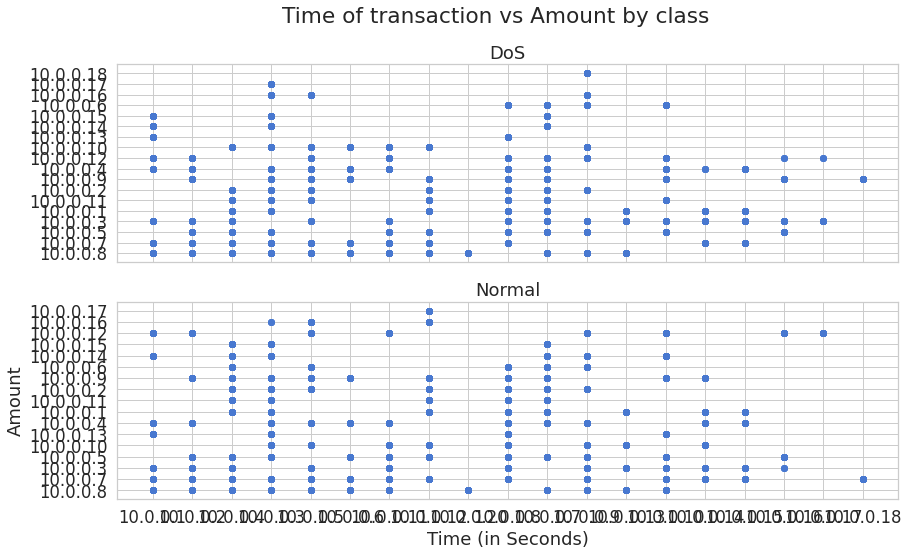

In [ ]:
# 일단 돌려보긴하는데 우리는 우리가 직접 데이터 셋을 가공해서 만들어야 할듯(아니면 DDoS랑 우리꺼랑 다 합쳐서 할까? 근데 그럼 timestamp가 필요할 것 같은데???)
# 생각해보자........

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
# 원하는 scatter로 바꾸기
ax1.scatter(dos.src, dos.dst)
ax1.set_title('DoS')

ax2.scatter(normal.src, normal.dst)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [ ]:
# 여기서부터 다시시작
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [ ]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [ ]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

In [ ]:
autoencoder = load_model('model.h5')

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [ ]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()